In [189]:
import pyxdf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

In [190]:
channels = ['Fp1', 'Fz', 'F3', 'F7', 'F9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7'
            , 'P9', 'O1', 'Oz', 'O2', 'P10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'C4', 'Cz'
            , 'FC2', 'FC6', 'F10', 'F8', 'F4', 'Fp2','AUX_1', 'ACC_X', 'ACC_Y', 'ACC_Z']
removed_channels = ['Fp1', 'F8', 'F7', 'Fp2', 'F3', 'F4']
# TODO ADD AUX WHEN CONNECTED
eye_data_names = ['x', 'y', 'z', 'left_blink', 'right_blink', 'both_blink', 'left_openness', 'right_openness']
columns =  eye_data_names + channels

data, header = pyxdf.load_xdf('data/LSLDataV2/LSLDataLeftFourTimes2/eeg-and-eyetracking.xdf')


print(header)

{'info': defaultdict(<class 'list'>, {'version': ['1'], 'notes': [None]})}


In [191]:
def get_time_stamps(stamps: list):
    start = []
    end = []
    more_than_one = False

    for i in range(len(stamps)):
        if i == (len(stamps)-1):
            if(stamps[i-1] == (stamps[i] - 1)):
                end.append(stamps[i])
            break

        if(stamps[i] == (stamps[i+1] - 1)):
            if not more_than_one:
                start.append(stamps[i])
            more_than_one = True
            continue
        else:
            if more_than_one:
                end.append(stamps[i])
                more_than_one = False

    return start, end

def plot_eeg_single(df,df_ts, column):
    axis = plt.subplot()
    axis.plot(df_ts['time'], df[column])
    axis.set_title(column)
    plt.show()

def plot_eeg(stream):
    df = pd.DataFrame(stream['time_series'])
    df.columns = columns
    index = 0
    for i in range(32):
        color = 'blue'
        index += 1
        if channels[i] in removed_channels:
            color = 'red'

        axis = plt.subplot()
        axis.plot(stream['time_stamps'], df[channels[i]], color=color)
        axis.set_title(channels[i])
        plt.show()







In [192]:
def plot_eeg_blink_single_norm(df,df_ts, start, end,column,rang = 50, scale=1):
    plt.figure(figsize=(10,6))
    df = df[start - rang:end + rang]
    df.columns = columns
    axis = plt.subplot()
    axis.axvline(df_ts['time'][start], color='green', label = "Blink start - TobiiXR")  # y = 0
    axis.axvline(df_ts['time'][end], color='red', label = "Blink End - TobiiXR")

    flip = -1 if df[column].min() < 0 else 1


    df_norm = (df[column].abs() / df[column].abs().max()) * flip
    plus = -df_norm[start - rang]
    axis.plot(df_ts['time'][start-rang:end+rang], (df_norm + plus) *scale, label = "EMG")
    axis.plot(df_ts['time'][start-rang:end+rang], (df['left_openness'] / df['left_openness'].abs().max())*(-1)+1, color='orange', label = "Eye openness - SRanipal")
    axis.set_xlabel("Time normalized (seconds)")
    axis.set_ylabel("Normalized charge")
    axis.set_title(column)
    plt.legend()
    plt.show()

def plot_eeg_blink_single(df,df_ts, start, end,column,rang = 50):
    plt.figure(figsize=(10,6))
    df = df[start - rang:end + rang]
    df.columns = columns
    axis = plt.subplot()
    axis.axvline(df_ts['time'][start], color='green', label = "Blink start - TobiiXR")  # y = 0
    axis.axvline(df_ts['time'][end], color='red', label = "Blink End - TobiiXR")

    axis.plot(df_ts['time'][start-rang:end+rang], df[column], label = "EMG")
    axis.plot(df_ts['time'][start-rang:end+rang], df['left_openness'], color='orange', label = "Eye openness - SRanipal")
    axis.set_title(column)
    plt.legend()
    plt.show()


def plot_eeg_blink_all(stream, start, end,rang = 50):
    df = pd.DataFrame(stream['time_series'])
    df.columns = columns
    df = df[start - rang:end + rang]
    index = 0
    for i in range(32):
        color = 'blue'
        index += 1
        if channels[i] in removed_channels:
            color = 'red'

        axis = plt.subplot()
        axis.axvline(stream['time_stamps'][start], color='red')  # y = 0
        axis.axvline(stream['time_stamps'][end], color='red')
        axis.plot(stream['time_stamps'][start-rang:end+rang], df[channels[i]], color=color)
        axis.set_title(channels[i])
        plt.show()

In [193]:
stream = None
df_stream = None
df_stream_ts = None
for s in data:
    stream = s
    y = stream['time_series']
    df_stream = pd.DataFrame(y)
    df_stream_ts = pd.DataFrame(stream['time_stamps'])
    df_stream_ts.columns = ['time']
    df_stream.columns = columns

def get_blinks_in_df(df):
    left_blinks = df.index[(df['left_blink'] >= 1) & (df['right_blink'] != 1)].tolist()
    right_blinks = df.index[(df['right_blink'] >= 1) & (df['left_blink'] != 1)].tolist()
    both_blink = df.index[df['both_blink'] == 1].tolist()
    return left_blinks,right_blinks, both_blink

left_blinks, right_blinks, both_blink = get_blinks_in_df(df_stream)

In [194]:

avg_time = np.diff(df_stream_ts.to_numpy().flatten()).tolist()

[1201, 1510, 1858]
[1278, 1576, 1917]


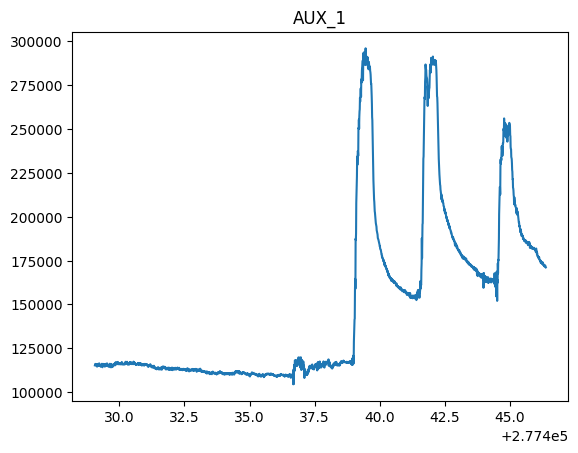

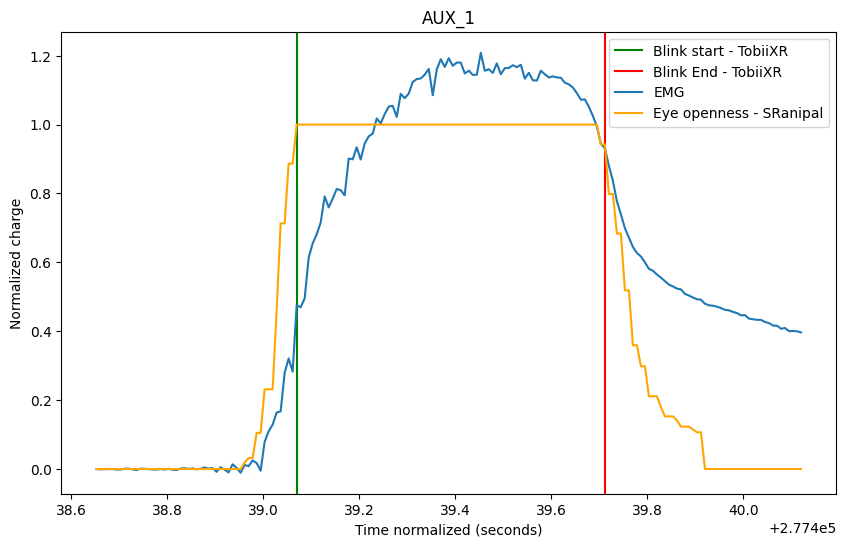

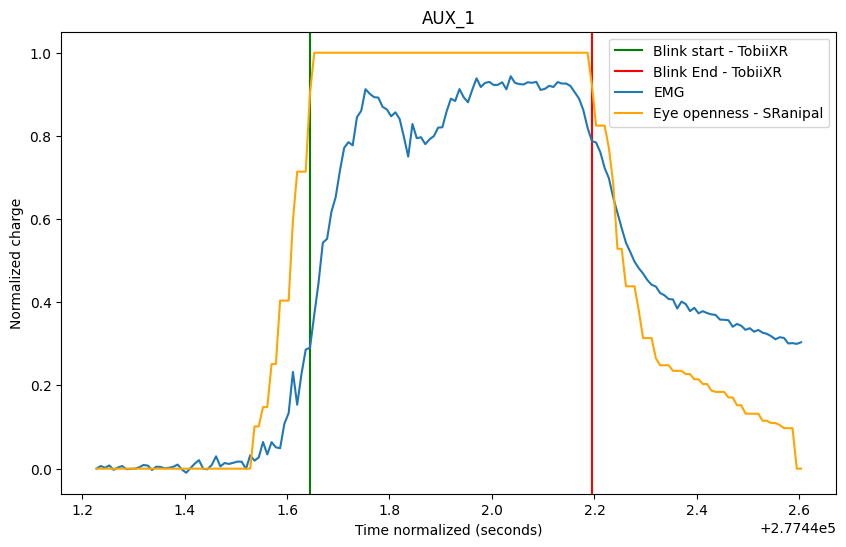

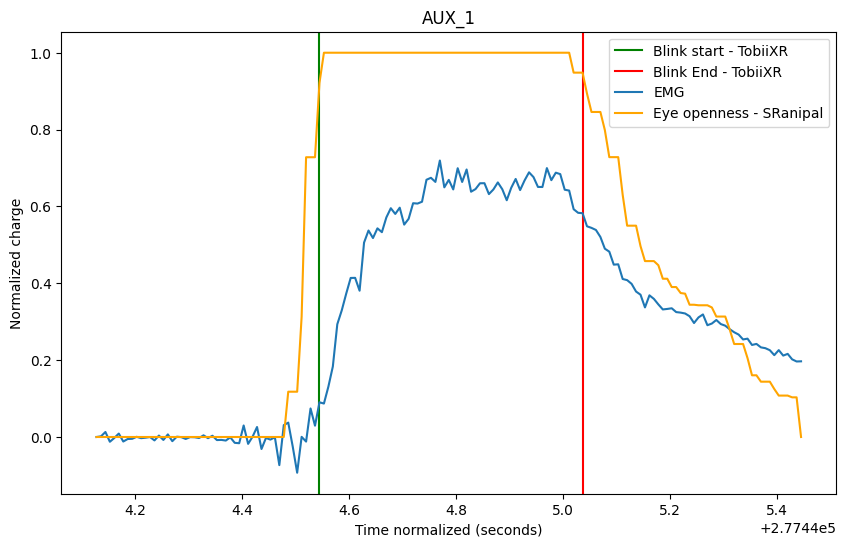

In [195]:
start, end = get_time_stamps(left_blinks)
chosen_channel = 'AUX_1'
print(start)
print(end)
df_stream['AUX_1'] = df_stream['AUX_1']
plot_eeg_single(df_stream, df_stream_ts, chosen_channel)
for i in range(len(start)):
    plot_eeg_blink_single_norm(df_stream,df_stream_ts, start[i], end[i], chosen_channel, 50, scale=2)
#plot_eeg_blink_all(stream, start[1], end[1])
#plot_eeg(stream)

In [196]:
from scipy.signal import butter, lfilter

